In [1]:
import random

import matplotlib.pyplot as plt
import numpy as np
from filterpy.common import Q_discrete_white_noise
from filterpy.kalman import EnsembleKalmanFilter as EnKF

SEED = 42
np.random.seed(SEED)
random.seed(SEED)

In [2]:
assimilation_window = 100
true_state_value = 1.0
noise_std = 0.05

true_state = np.ones(assimilation_window) * true_state_value
measurement_noise = np.random.normal(
    loc=0.0, scale=noise_std, size=assimilation_window
)
measurements = true_state + measurement_noise

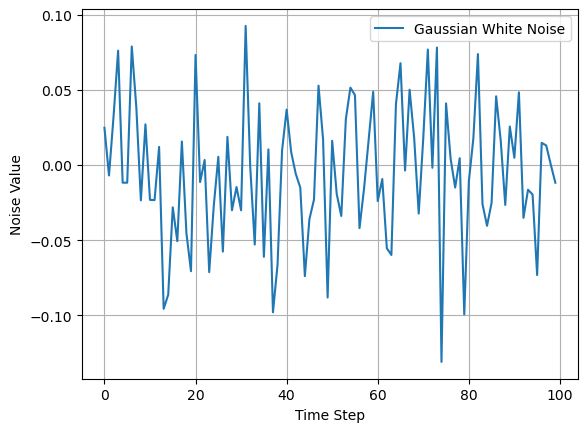

In [3]:
plt.figure()
plt.plot(measurement_noise, label="Gaussian White Noise")
plt.xlabel("Time Step")
plt.ylabel("Noise Value")
plt.grid(True)
plt.legend()
plt.show()

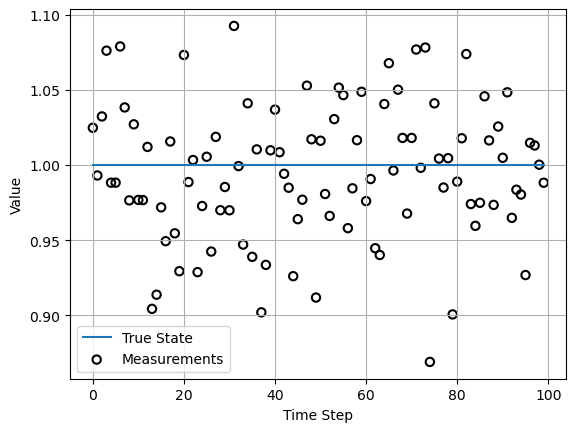

In [4]:
plt.figure()
plt.plot(true_state, label="True State")
plt.scatter(
    np.arange(assimilation_window),
    measurements,
    facecolors="none",
    edgecolors="k",
    lw=1.5,
    label="Measurements",
)
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.grid(True)
plt.legend()
plt.show()

In [5]:
F = np.array([[1.0, 0.0], [0.0, 1.0]])


def hx(x):
    return np.array([x[0]])


def fx(x, dt):
    return F @ x

In [6]:
initial_state = np.array([0.0, 0.0])
initial_cov = np.eye(2) * 0.1

enkf = EnKF(
    x=initial_state, P=initial_cov, dim_z=1, dt=1.0, N=10, hx=hx, fx=fx
)
enkf.R *= 0.1
enkf.Q = Q_discrete_white_noise(dim=2, dt=0.001, var=0.001)

In [7]:
estimates = []
uncertainties = []

for t in range(assimilation_window):
    z = measurements[t]

    enkf.predict()
    enkf.update(np.array([z]))

    estimates.append(enkf.x[0])
    uncertainties.append(3 * np.sqrt(enkf.P[0, 0]))  # 3-sigma bounds

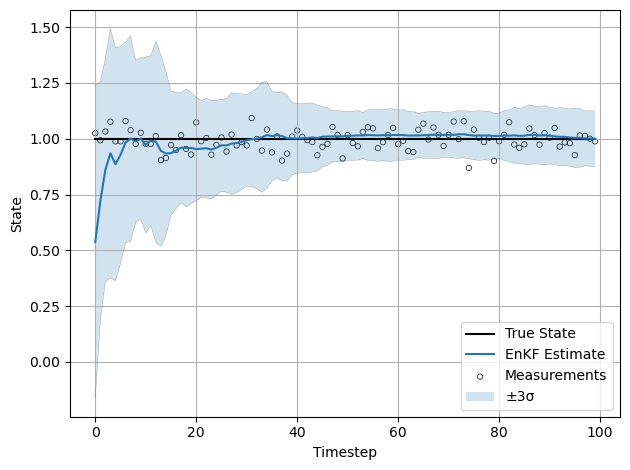

In [8]:
estimates = np.array(estimates)
uncertainties = np.array(uncertainties)

plt.figure()
plt.plot(true_state, label="True State", c="k")
plt.plot(estimates, label="EnKF Estimate")
plt.scatter(
    np.arange(assimilation_window),
    measurements,
    facecolors="none",
    s=15,
    edgecolors="k",
    lw=0.5,
    label="Measurements",
)

plt.fill_between(
    np.arange(assimilation_window),
    estimates - uncertainties,
    estimates + uncertainties,
    alpha=0.2,
    label="±3σ",
)

plt.plot(estimates - uncertainties, color="k", lw=0.1)
plt.plot(estimates + uncertainties, color="k", lw=0.1)

plt.xlabel("Timestep")
plt.ylabel("State")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()